
<div align="center"><img width="275" height="50" src="http://www.essentiallysports.com/wp-content/uploads/f1-logo.jpg"/> </div> 

<div align="center"> <h1>NLP Project</h1> 
  <h6> by David Berchelmann -- May 11, 2021 </h6> </div>
  
  ------------------------------------------------

<div align="center"><img width="800" height="50" src="https://communityimpact.com/wp-content/uploads/2016/10/cropCircuitoftheAmericas_USGP_20151023_Rizzo_89640-2.jpg" /> </div>

-----

-------

<h1> Welcome! </h1>

The following jupyter notebook will take you through my NLP project focusing on predicting the programming languages that make up git hub repositories that focus on Formula 1.  

All of the files and notebooks for this project can be accessed via the github repostiory located at --> https://github.com/DBerchelmann/nlp-project



----

<h1> Executive Summary </h1>

------

<h4><b>The Problem</b></h4>

- Can a repository's programming language be determined by a model built off of natural language processing?

<h4><b>The Goal</b></h4>

- Create a predictive model using natural language processing that can determine the dominant programming language used in github repositories based on the text of the README files.

<h4><b>The Process</b></h4>

  * Acquire the Data
  * Prepare 
  * Explore 
  * Model
  * Findings/Recommendations
  
<h4><b>The Findings</b></h4>


    
    
 


-------



<h3><u>Environment Setup</u></h3>

------

In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
import numpy as np
import bs4
import time

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import unicodedata
import re

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

from env import github_token, github_username

import acquire, wrangle, explore
from wrangle import clean_nlp

---
<h3><u>Acquire the Data</u></h3>

----

The acquire section took several steps before it could be read into the notebook as a csv.

- Use a function to search a pre-determined amount of pages based on a search for github repository URLs that had the highest star rankings which covered Formula 1.
- Next,those URLs were inputted into another function which then used web scraping to bring back the repository name, the dominant language it was written in, and the text contents of the READEME file.
- Finally, that list of dictionaries was converted into a pandas data frame which was then written into a CSV.
- After being written into a CSV, I was able to read it back into this notebook as a CSV which will allow for much faster preparation, exploring, and modeling.

In [2]:
df = wrangle.acquire_csv()

In [3]:
df.shape

(268, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   repo              268 non-null    object
 1   language          241 non-null    object
 2   readme_contents   268 non-null    object
 3   written_language  268 non-null    object
dtypes: object(4)
memory usage: 8.5+ KB


<h3>Takeaways</h3>

- We have some nulls in README that will need to be investigated. NLP needs text to read to be able to predict


---
<h3><u>Prepare the Data</u></h3>

----

<h4>Initial Findings</h4>

- I saw that while a majority of the readme files were inEnglish, there were a number of them in different languages. 
- I utilized a language detection import called TextBlob that allowed me to decipher those languages.
    -With that, I utilized value counts to only keep repositories that had a language in 6 or more total repositories. 
     - this data set contains repositories with English, Portuguese, Spanish, & French stop words
      - by doing this, our models will be able give a more equal weight across the board by taking out unnecessary words in all the included languages
- All nulls were also dropped
- Finally, any computer language that wasn't included in 7 more libraries was dropped as well


In [5]:
df = wrangle.first_clean()

In [6]:
df.head()

,repo,language,readme_contents,written_language
0,ppatierno/formula1-telemetry-kafka,Java,# Formula 1 - Telemetry with Apache Kafka\n\nT...,en
2,jcnewell/ergast-f1-api,PHP,# Ergast nodeJS API\nIn this period we are wor...,en
5,izenecloud/sf1r-lite,C++,SF1R-Lite(Search Formula-1 Lite Engine)\n=====...,en
7,jonybur/f1-telemetry-client,TypeScript,"# F1 Telemetry Client\n\n<img src=""https://img...",en
8,davidor/formula1-lap-charts,JavaScript,# Formula 1 Lap Charts\n\nInteractive lap char...,en


---
<h3><u>Explore the Data</u></h3>

----

In [7]:
explore.show_counts_and_ratios(df, "language")

,n,percent
JavaScript,50,0.268817
Python,27,0.145161
HTML,20,0.107527
C++,14,0.075269
Java,13,0.069892
PHP,13,0.069892
TypeScript,12,0.064516
Ruby,11,0.059140
C#,10,0.053763
Jupyter Notebook,9,0.048387


<h4>Takeaways</h4>

- A majority of these repositories are written in Javascript, followed by Python and then HTML. 
- I believe our model will be able to predict these first three fairly accurately since it will have the most data

-------

<h4>Now Let's Really Explore</h4>

  - we will use the clean_nlp function to clean each language separately so we can explore more in-depth
------

In [9]:
# seperate the data into seperate pieces 

js = clean_nlp(' '.join(df[df.language == 'JavaScript'].readme_contents))

python = clean_nlp(' '.join(df[df.language == 'Python'].readme_contents))

html = clean_nlp(' '.join(df[df.language == 'HTML'].readme_contents))

php = clean_nlp(' '.join(df[df.language == 'PHP'].readme_contents))

cplus = clean_nlp(' '.join(df[df.language == 'C++'].readme_contents))

java = clean_nlp(' '.join(df[df.language == 'Java'].readme_contents))

csharp = clean_nlp(' '.join(df[df.language == 'C#'].readme_contents))

type_script = clean_nlp(' '.join(df[df.language == 'TypeScript'].readme_contents))

ruby = clean_nlp(' '.join(df[df.language == 'Ruby'].readme_contents))

r = clean_nlp(' '.join(df[df.language == 'R'].readme_contents))

c = clean_nlp(' '.join(df[df.language == 'C'].readme_contents))

css = clean_nlp(' '.join(df[df.language == 'CSS'].readme_contents))

jup = clean_nlp(' '.join(df[df.language == 'Jupyter Notebook'].readme_contents))

all_words = clean_nlp(' '.join(df.readme_contents))

In [15]:
df.groupby('language').written_language.value_counts().to_frame()

written_language
language         written_language                  
C#               en                              10
C++              en                              13
                 pt                               1
HTML             en                              12
                 es                               3
                 fr                               3
                 pt                               2
Java             en                              11
                 pt                               2
JavaScript       en                              46
                 es                               2
                 pt                               2
Jupyter Notebook en                               9
PHP              en                              10
                 fr                               3
Python           en                              25
                 pt                               2
R                en                               6
                 pt                               1
Ruby             en                              11
TypeScript       en                              10
                 es                               1
                 pt                               1

<h4>Takeaways</h4>

- English is the dominant language of the README files for each of the programming languages
- Ruby, Jupyter Notebook, & C Sharp are the only languages to have README files solely in English

In [10]:
# get word frequencies for each language

js_freq = pd.Series(js).value_counts()
python_freq = pd.Series(python).value_counts()
html_freq = pd.Series(html).value_counts()
php_freq = pd.Series(php).value_counts()
cplus_freq = pd.Series(cplus).value_counts()
java_freq = pd.Series(java).value_counts()
csharp_freq = pd.Series(csharp).value_counts()
type_script_freq = pd.Series(type_script).value_counts()
ruby_freq = pd.Series(ruby).value_counts()
r_freq = pd.Series(r).value_counts()
c_freq = pd.Series(c).value_counts()
css_freq = pd.Series(css).value_counts()
jup_freq = pd.Series(jup).value_counts()
all_freq = pd.Series(all_words).value_counts()

<ipython-input-10-8e8c4682fba7>:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  c_freq = pd.Series(c).value_counts()
<ipython-input-10-8e8c4682fba7>:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  css_freq = pd.Series(css).value_counts()


In [14]:
# Get a total word counts column by concating all langauge word frequencies.

word_counts = (pd.concat([all_freq,
                          js_freq,
                          python_freq,
                          html_freq,
                          php_freq,
                          cplus_freq,
                          java_freq,
                          csharp_freq,
                          type_script_freq,
                          ruby_freq,
                         r_freq,
                         c_freq,
                         css_freq,
                         jup_freq], axis=1, sort=True)
                .set_axis(['all', 'js', 'python', 'html', 'php','cplus', 'java', 'csharp', 'typescript', 'ruby', 'r', 'c', 'css', 'jup'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))


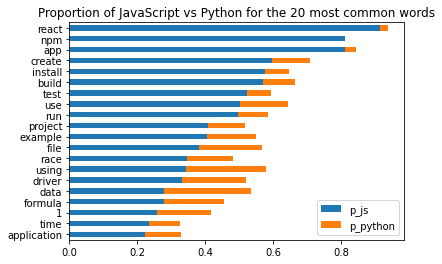

In [19]:
 # figure out the percentage of Javascript vs Python
(word_counts
 .assign(p_js=word_counts.js / word_counts['all'],
         p_python=word_counts.python / word_counts['all'])
 .sort_values(by='all')
 [['p_js', 'p_python']]
 .tail(20)
 .sort_values('p_js')
 .plot.barh(stacked=True))

plt.title('Proportion of JavaScript vs Python for the 20 most common words')
plt.show()

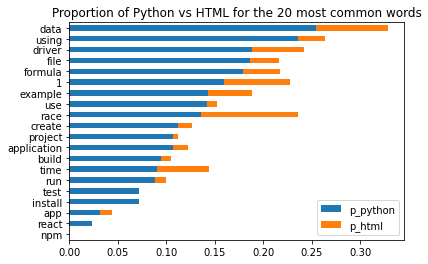

In [21]:
 # figure out the percentage of Python vs HTML
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_html=word_counts.html / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_html']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportion of Python vs HTML for the 20 most common words')
plt.show()

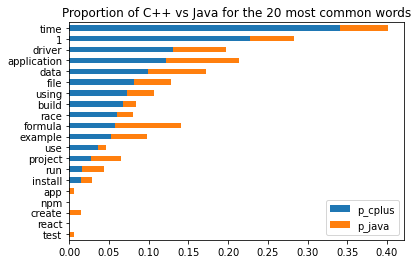

In [23]:
 # figure out the percentage of C ++ vs Java
(word_counts
 .assign(p_cplus=word_counts.cplus / word_counts['all'],
         p_java=word_counts.java / word_counts['all'])
 .sort_values(by='all')
 [['p_cplus', 'p_java']]
 .tail(20)
 .sort_values('p_cplus')
 .plot.barh(stacked=True))

plt.title('Proportion of C++ vs Java for the 20 most common words')
plt.show()

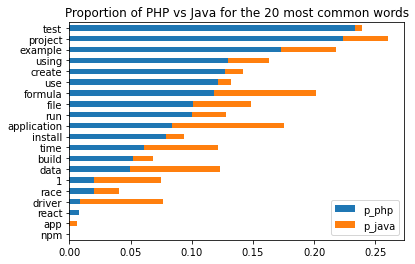

In [24]:
 # figure out the percentage of php vs java
(word_counts
 .assign(p_php=word_counts.php / word_counts['all'],
         p_java=word_counts.java / word_counts['all'])
 .sort_values(by='all')
 [['p_php', 'p_java']]
 .tail(20)
 .sort_values('p_php')
 .plot.barh(stacked=True))

plt.title('Proportion of PHP vs Java for the 20 most common words')
plt.show()

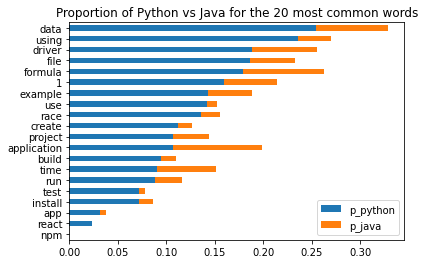

In [26]:
 # figure out the percentage of Python vs Java
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_java=word_counts.java / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_java']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportion of Python vs Java for the 20 most common words')
plt.show()